# **Libraries**

In [275]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from __init__ import *


# Modelling
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [276]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.width", 500)

# **Datasets**

In [277]:
data = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")
sample = pd.read_csv("Data/sample_submission.csv")

In [278]:
data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.00,3,0.00,2,1.00,0.00,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.00,1,0.00,2,1.00,1.00,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.00,10,0.00,2,1.00,0.00,184866.69,0
3,3,15741417,Kao,581,France,Male,34.00,2,148882.54,1,1.00,1.00,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.00,5,0.00,2,1.00,1.00,15068.83,0


In [279]:
test.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.00,2,0.00,2,0.00,1.00,160976.75
1,165035,15782418,Nott,683,France,Female,46.00,2,0.00,1,1.00,0.00,72549.27
2,165036,15807120,K?,656,France,Female,34.00,7,0.00,2,1.00,0.00,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.00,8,0.00,1,1.00,0.00,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.00,10,121263.62,1,1.00,0.00,139431.00


In [280]:
data.drop("id", axis = 1, inplace = True)
test.drop("id", axis = 1, inplace = True)

In [281]:
data_summary(data)

############## SHAPE ##############
165034
############## TYPES ##############
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object
############## NULL ##############
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
############ DESCRIBE ############
                    count        mean      std         min          0%         25%         50%         75%         90%         95%         99%         max
CustomerId      165034.00 15692005.02 71397.8

In [282]:
data_summary(test)

############## SHAPE ##############
110023
############## TYPES ##############
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
dtype: object
############## NULL ##############
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64
############ DESCRIBE ############
                    count        mean      std         min          0%         25%         50%         75%         90%         95%         99%         max
CustomerId      110023.00 15692096.61 71684.99 15565701.00 15565701.00 15632859.00 15690175.0

# **EDA**

In [283]:
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.00,3,0.00,2,1.00,0.00,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.00,1,0.00,2,1.00,1.00,49503.50,0
2,15694510,Hsueh,678,France,Male,40.00,10,0.00,2,1.00,0.00,184866.69,0
3,15741417,Kao,581,France,Male,34.00,2,148882.54,1,1.00,1.00,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.00,5,0.00,2,1.00,1.00,15068.83,0


In [284]:
pd.DataFrame({
    "Customer_count" : data.groupby(["Geography", "Gender"])["CustomerId"].count(),
    "Exited_count": data.groupby(["Geography", "Gender"])["Exited"].sum(),
    "Target_ratio": (data.groupby(["Geography", "Gender"])["Exited"].sum() / data.groupby("Geography")["CustomerId"].count()) *100,
    "Total_ratio": (data.groupby(["Geography", "Gender"])["Exited"].sum() / data["Exited"].shape[0]) *100,
    "Salary_mean": data.groupby(["Geography", "Gender"])["EstimatedSalary"].mean()
})

Customer_count  Exited_count  Target_ratio  Total_ratio  Salary_mean
Geography Gender                                                                      
France    Female           39976          9002          9.55         5.45    112752.81
          Male             54239          6570          6.97         3.98    112285.74
Germany   Female           16388          7596         21.95         4.60    114748.88
          Male             18218          5518         15.95         3.34    113085.45
Spain     Female           15520          3507          9.68         2.13    111883.21
          Male             20693          2728          7.53         1.65    111336.08

In [285]:
print(f"Count of Surname: {data['Surname'].nunique()}")
print(f"Count of Customer Id: {data['CustomerId'].nunique()}")

Count of Surname: 2797
Count of Customer Id: 23221


In [286]:
data.loc[data["CustomerId"] == 15660878]

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1329,15660878,T'ien,743,France,Male,76.00,9,126076.24,1,1.00,1.00,34436.83,0
11256,15660878,Ndubueze,714,Spain,Male,25.00,1,0.00,2,1.00,1.00,103381.77,0
43508,15660878,T'ien,752,France,Male,92.00,1,126076.24,2,1.00,1.00,34436.83,0
49584,15660878,Flannery,638,France,Male,39.00,3,0.00,2,0.00,1.00,105080.53,0
74699,15660878,T'ien,696,France,Male,92.00,9,0.00,1,0.00,1.00,163563.07,1
86176,15660878,T'ien,545,Germany,Female,38.00,3,114754.08,1,1.00,0.00,136050.44,0
94261,15660878,T'ien,705,France,Male,42.00,1,126076.24,2,1.00,1.00,34436.83,0
121560,15660878,T'ien,775,Spain,Male,92.00,1,126076.24,2,1.00,1.00,34436.83,0
139905,15660878,Brown,610,France,Female,47.00,1,0.00,2,0.00,1.00,80178.54,0


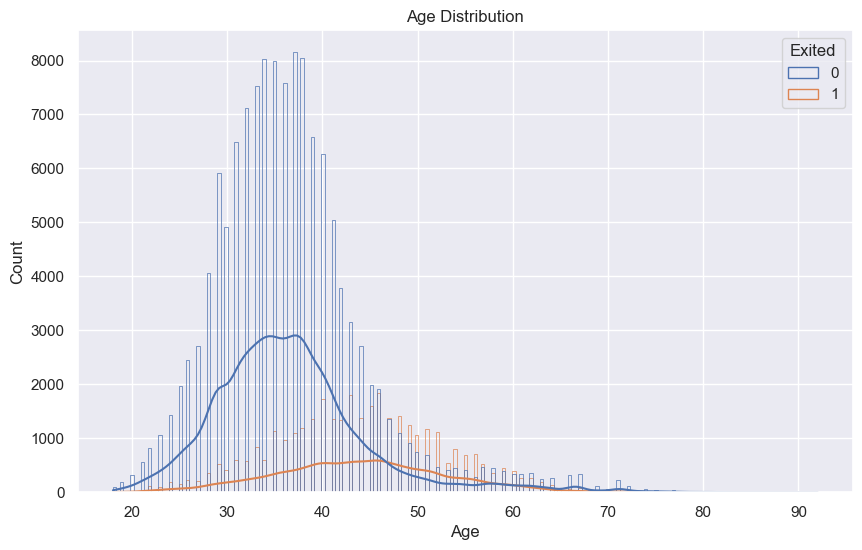

In [287]:
plt.figure(figsize=(10,6))
sns.histplot(data=data, x = "Age", kde=True, fill = False, hue = "Exited")
plt.title("Age Distribution")
plt.show()

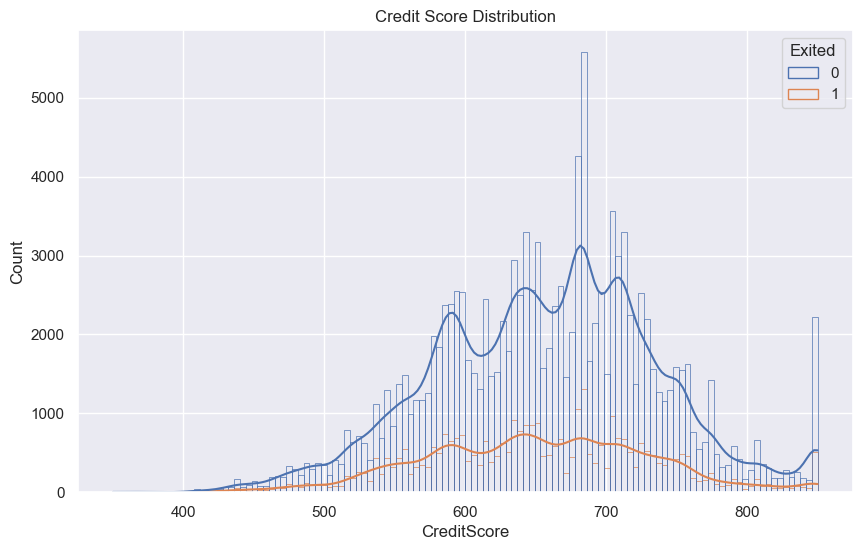

In [288]:
plt.figure(figsize=(10,6))
sns.histplot(data=data, x = "CreditScore", kde=True, fill = False, hue = "Exited")
plt.title("Credit Score Distribution")
plt.show()

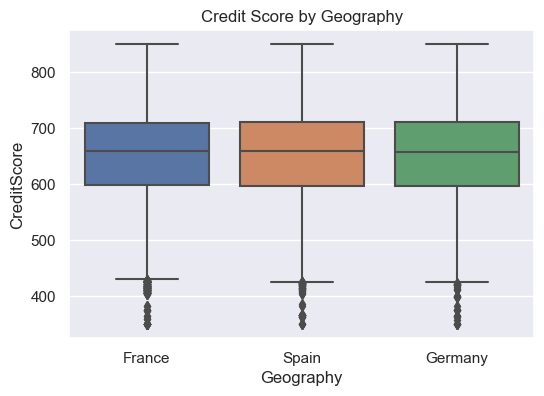

In [289]:
sns.boxplot(data=data, x="Geography", y="CreditScore")
plt.title("Credit Score by Geography")
plt.show()

In [290]:

data["Status"] = pd.cut(data["Age"],
                          bins = [data["Age"].min(), 22, 55, data["Age"].max()],
                          labels= ["Student","Employee","Retired"])

In [291]:
test["Status"] = pd.cut(test["Age"],
                          bins = [test["Age"].min(), 22, 55, test["Age"].max()],
                          labels= ["Student","Employee","Retired"])

Text(0.5, 1.0, 'Estimated Salary by Status')

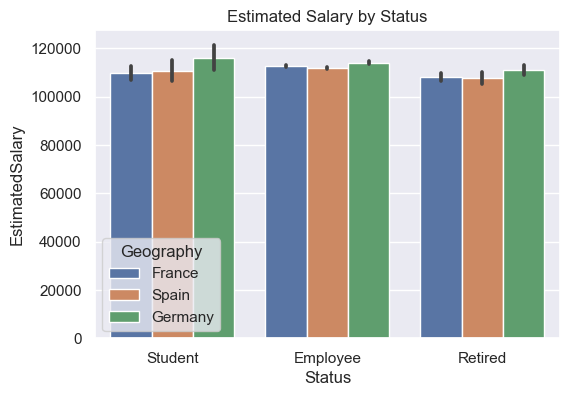

In [292]:
sns.barplot(x = "Status", 
            y = "EstimatedSalary", 
            hue = "Geography" ,
            data = data)
plt.title("Estimated Salary by Status")

In [293]:
data.groupby(["Geography","Status"])["Balance"].sum()

Geography  Status  
France     Student      45443833.34
           Employee   3291051678.88
           Retired     180131491.26
Germany    Student      38735412.34
           Employee   3891314449.50
           Retired     261844159.33
Spain      Student      22965031.36
           Employee   1336913679.35
           Retired      79943308.66
Name: Balance, dtype: float64

Text(0.5, 1.0, 'Total Balance for Each Status')

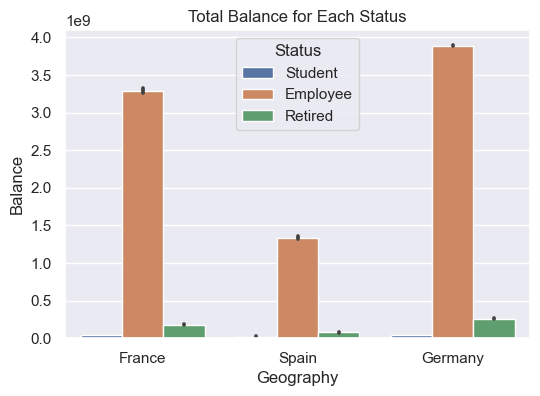

In [294]:
sns.barplot(x = "Geography", 
            y = "Balance", 
            hue = "Status",
            estimator="sum",
            data = data)
plt.title("Total Balance for Each Status")

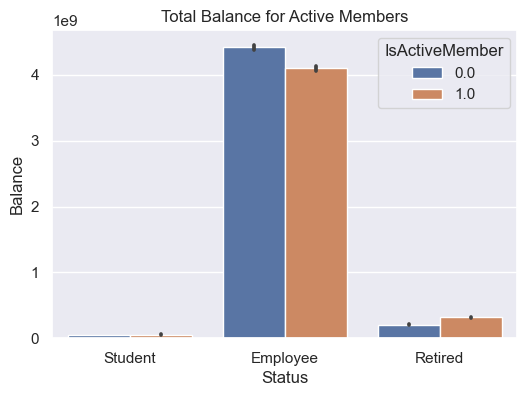

In [295]:
sns.barplot(x = "Status", 
            y = "Balance", 
            hue = "IsActiveMember",
            estimator="sum",
            data = data)
plt.title("Total Balance for Active Members")
plt.show()

This shows us that non-active employee group members have the largest balance in their accounts.

In [296]:
data["Empty_Balance"] = np.where(data["Balance"] == 0.00, 0, 1)   
test["Empty_Balance"] = np.where(test["Balance"] == 0.00, 0, 1)   

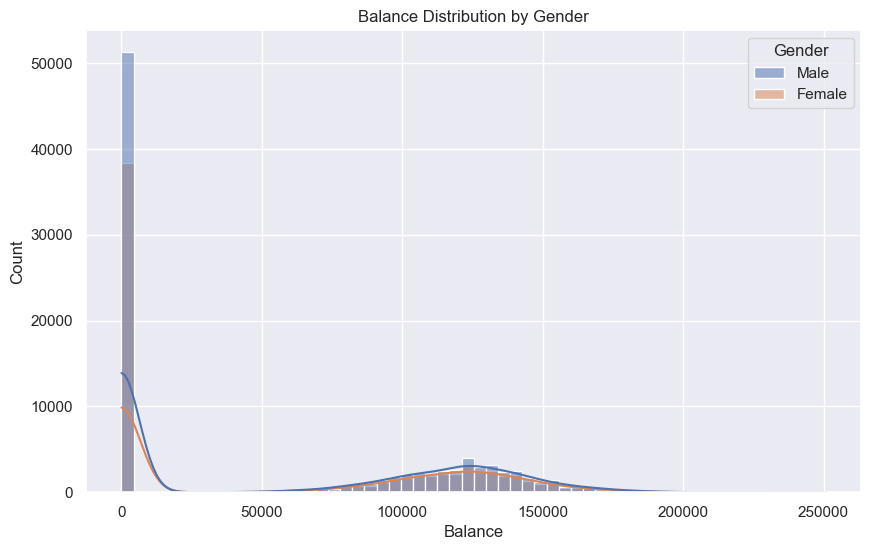

In [297]:
plt.figure(figsize=(10,6))
sns.histplot(data = data, x = "Balance", hue = "Gender", kde=True)
plt.title("Balance Distribution by Gender")
plt.show()

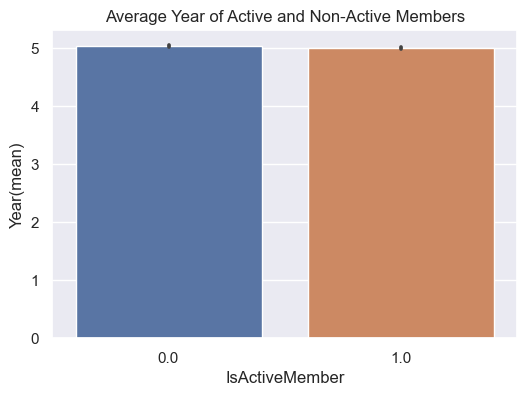

In [298]:
sns.barplot(x = "IsActiveMember", 
            y = "Tenure",
            data = data)
plt.title("Average Year of Active and Non-Active Members")
plt.ylabel("Year(mean)")
plt.show()

In [299]:
data["product_per_year"] = data["NumOfProducts"] / data["Tenure"]
test["product_per_year"] = test["NumOfProducts"] / test["Tenure"]

This will show us how many products customers get on average per year.

In [300]:
data["UnitBalance_per_Product"] = data["Balance"] / data["NumOfProducts"]
test["UnitBalance_per_Product"] = data["Balance"] / data["NumOfProducts"]

This will show us how much money customers have per product.

In [301]:
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Status,Empty_Balance,product_per_year,UnitBalance_per_Product
0,15674932,Okwudilichukwu,668,France,Male,33.00,3,0.00,2,1.00,0.00,181449.97,0,Employee,0,0.67,0.00
1,15749177,Okwudiliolisa,627,France,Male,33.00,1,0.00,2,1.00,1.00,49503.50,0,Employee,0,2.00,0.00
2,15694510,Hsueh,678,France,Male,40.00,10,0.00,2,1.00,0.00,184866.69,0,Employee,0,0.20,0.00
3,15741417,Kao,581,France,Male,34.00,2,148882.54,1,1.00,1.00,84560.88,0,Employee,1,0.50,148882.54
4,15766172,Chiemenam,716,Spain,Male,33.00,5,0.00,2,1.00,1.00,15068.83,0,Employee,0,0.40,0.00


In [302]:
# Label Encoder

lab = LabelEncoder()
data["Gender"] = lab.fit_transform(data["Gender"])
print(lab.inverse_transform([0,1]))

test["Gender"] = lab.fit_transform(test["Gender"])
print(lab.inverse_transform([0,1]))

data["Geography"] = lab.fit_transform(data["Geography"])
print(lab.inverse_transform([0,1,2]))

test["Geography"] = lab.fit_transform(test["Geography"])
print(lab.inverse_transform([0,1,2]))

data["Status"] = lab.fit_transform(data["Status"])
print(lab.inverse_transform([0,1,2]))

test["Status"] = lab.fit_transform(test["Status"])
print(lab.inverse_transform([0,1,2]))

['Female' 'Male']
['Female' 'Male']
['France' 'Germany' 'Spain']
['France' 'Germany' 'Spain']
['Employee' 'Retired' 'Student']
['Employee' 'Retired' 'Student']


C:\Users\BETÜL DEMİRDAĞ\AppData\Local\Temp\ipykernel_1888\232394746.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()[['Exited']]


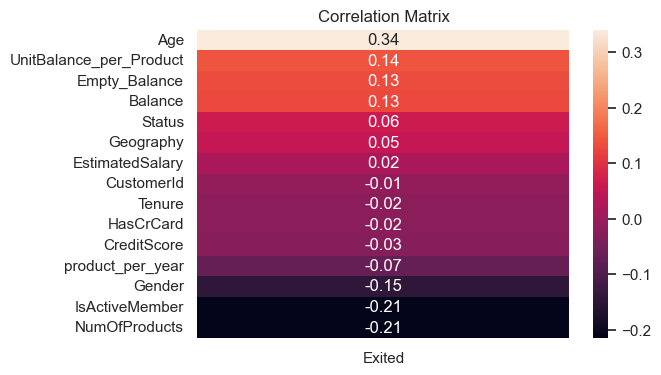

In [303]:
corr_matrix = data.corr()[['Exited']]
sns.set(rc={'figure.figsize': (6, 4)})
corr_matrix.drop(['Exited'], axis=0, inplace=True)
sns.heatmap(corr_matrix.sort_values(by='Exited', ascending=False), annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [304]:
data.drop(["CustomerId", "Surname"], axis = 1, inplace=True)
test.drop(["CustomerId", "Surname"], axis = 1, inplace=True)

In [305]:
data.dtypes

CreditScore                  int64
Geography                    int32
Gender                       int32
Age                        float64
Tenure                       int64
Balance                    float64
NumOfProducts                int64
HasCrCard                  float64
IsActiveMember             float64
EstimatedSalary            float64
Exited                       int64
Status                       int32
Empty_Balance                int32
product_per_year           float64
UnitBalance_per_Product    float64
dtype: object

# **Outlier Detection for data**

In [306]:
data = data.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

lof = LocalOutlierFactor()
lof.fit_predict(data)
data_scores = lof.negative_outlier_factor_
np.sort(data_scores)[0:50]
    

array([-543.99825443, -530.3992844 , -500.41408049, -470.31089499,
       -455.54589794, -451.55396044, -426.9890451 , -420.025141  ,
       -373.97752494, -357.32096699, -351.9996033 , -311.24302695,
       -252.15660711, -252.15660672, -252.15660409, -250.24632831,
       -209.18871327, -173.33454123, -144.35363651, -144.35338719,
       -142.92171744, -117.83030483, -100.11886241,  -32.06700277,
         -6.19609227,   -5.6962943 ,   -5.5279903 ,   -5.11959474,
         -4.41641511,   -4.41232121,   -4.30135004,   -4.24215864,
         -4.22432801,   -3.91342547,   -3.87709529,   -3.86323807,
         -3.86321879,   -3.86318156,   -3.81560631,   -3.77865154,
         -3.76728466,   -3.74865477,   -3.71944834,   -3.71764518,
         -3.68218723,   -3.66900898,   -3.66726231,   -3.64108602,
         -3.60792819,   -3.58503891])

There are 24 outliers

In [307]:
threshold = np.sort(data_scores)[24]
threshold_data = data[data_scores == threshold]
threshold_data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Status,Empty_Balance,product_per_year,UnitBalance_per_Product
3651,578,0,1,32.00,2,0.00,1,0.00,1.00,64139.10,0,0,0,0.50,0.00


In [308]:
data[data_scores < threshold].shape

(24, 15)

In [309]:
# Some index operations must be performed to make the outliers equal to the threshold value.

ind = data[data_scores < threshold].to_records(index = False)
ind[:] = threshold_data.to_records(index = False)
ind

rec.array([(578, 0, 1, 32., 2, 0., 1, 0., 1., 64139.1, 0, 0, 0, 0.5, 0.),
           (578, 0, 1, 32., 2, 0., 1, 0., 1., 64139.1, 0, 0, 0, 0.5, 0.),
           (578, 0, 1, 32., 2, 0., 1, 0., 1., 64139.1, 0, 0, 0, 0.5, 0.),
           (578, 0, 1, 32., 2, 0., 1, 0., 1., 64139.1, 0, 0, 0, 0.5, 0.),
           (578, 0, 1, 32., 2, 0., 1, 0., 1., 64139.1, 0, 0, 0, 0.5, 0.),
           (578, 0, 1, 32., 2, 0., 1, 0., 1., 64139.1, 0, 0, 0, 0.5, 0.),
           (578, 0, 1, 32., 2, 0., 1, 0., 1., 64139.1, 0, 0, 0, 0.5, 0.),
           (578, 0, 1, 32., 2, 0., 1, 0., 1., 64139.1, 0, 0, 0, 0.5, 0.),
           (578, 0, 1, 32., 2, 0., 1, 0., 1., 64139.1, 0, 0, 0, 0.5, 0.),
           (578, 0, 1, 32., 2, 0., 1, 0., 1., 64139.1, 0, 0, 0, 0.5, 0.),
           (578, 0, 1, 32., 2, 0., 1, 0., 1., 64139.1, 0, 0, 0, 0.5, 0.),
           (578, 0, 1, 32., 2, 0., 1, 0., 1., 64139.1, 0, 0, 0, 0.5, 0.),
           (578, 0, 1, 32., 2, 0., 1, 0., 1., 64139.1, 0, 0, 0, 0.5, 0.),
           (578, 0, 1, 32., 2, 0., 1, 

In [310]:
data[data_scores < threshold] = pd.DataFrame(ind, index = data[data_scores < threshold].index)
data[data_scores < threshold]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Status,Empty_Balance,product_per_year,UnitBalance_per_Product
4248,578,0,1,32.00,2,0.00,1,0.00,1.00,64139.10,0,0,0,0.50,0.00
4747,578,0,1,32.00,2,0.00,1,0.00,1.00,64139.10,0,0,0,0.50,0.00
5768,578,0,1,32.00,2,0.00,1,0.00,1.00,64139.10,0,0,0,0.50,0.00
10890,578,0,1,32.00,2,0.00,1,0.00,1.00,64139.10,0,0,0,0.50,0.00
13556,578,0,1,32.00,2,0.00,1,0.00,1.00,64139.10,0,0,0,0.50,0.00
15619,578,0,1,32.00,2,0.00,1,0.00,1.00,64139.10,0,0,0,0.50,0.00
21895,578,0,1,32.00,2,0.00,1,0.00,1.00,64139.10,0,0,0,0.50,0.00
28079,578,0,1,32.00,2,0.00,1,0.00,1.00,64139.10,0,0,0,0.50,0.00
34596,578,0,1,32.00,2,0.00,1,0.00,1.00,64139.10,0,0,0,0.50,0.00
38285,578,0,1,32.00,2,0.00,1,0.00,1.00,64139.10,0,0,0,0.50,0.00


# **Outlier Detection for test**

In [311]:
test = test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

lof.fit_predict(test)
test_scores = lof.negative_outlier_factor_
np.sort(test_scores)[0:50]

array([-246.99739899, -246.99738448, -198.83742176, -197.31563308,
       -177.20207809, -174.29463193, -129.56221944, -110.72135276,
       -110.00644266, -109.27768928,  -93.15748159,  -92.37128493,
        -89.52886402,  -89.41307178,  -85.26705792,  -75.54583703,
        -73.95208644,  -72.15031161,  -64.18619519,  -63.56047235,
        -47.65961347,  -46.53526354,  -38.41901064,  -37.26466521,
        -21.12030807,  -18.84388166,  -13.36645598,  -13.26797849,
        -12.09010147,  -11.55961659,  -10.32291636,  -10.08382285,
         -9.77571899,   -9.30975797,   -8.20807742,   -8.04522188,
         -7.88717061,   -7.43727231,   -6.99964166,   -6.94057291,
         -6.84061155,   -6.59642382,   -6.18740522,   -6.18172861,
         -5.77568403,   -5.53127458,   -5.43060617,   -5.17688336,
         -4.96661143,   -4.92967803])

There are 26 outliers

In [312]:
threshold_t = np.sort(test_scores)[26]
threshold_test = test[test_scores == threshold_t]
threshold_test

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Status,Empty_Balance,product_per_year,UnitBalance_per_Product
68646,718,0,1,45.00,8,24043.45,1,0.00,1.00,169781.45,0,1,0.12,102541.17


In [313]:
test[test_scores < threshold_t].shape

(26, 14)

In [314]:
test_ind = test[test_scores < threshold_t].to_records(index = False)
test_ind[:] = threshold_test.to_records(index = False)
test_ind

rec.array([(718, 0, 1, 45., 8, 24043.45, 1, 0., 1., 169781.45, 0, 1, 0.125, 102541.17),
           (718, 0, 1, 45., 8, 24043.45, 1, 0., 1., 169781.45, 0, 1, 0.125, 102541.17),
           (718, 0, 1, 45., 8, 24043.45, 1, 0., 1., 169781.45, 0, 1, 0.125, 102541.17),
           (718, 0, 1, 45., 8, 24043.45, 1, 0., 1., 169781.45, 0, 1, 0.125, 102541.17),
           (718, 0, 1, 45., 8, 24043.45, 1, 0., 1., 169781.45, 0, 1, 0.125, 102541.17),
           (718, 0, 1, 45., 8, 24043.45, 1, 0., 1., 169781.45, 0, 1, 0.125, 102541.17),
           (718, 0, 1, 45., 8, 24043.45, 1, 0., 1., 169781.45, 0, 1, 0.125, 102541.17),
           (718, 0, 1, 45., 8, 24043.45, 1, 0., 1., 169781.45, 0, 1, 0.125, 102541.17),
           (718, 0, 1, 45., 8, 24043.45, 1, 0., 1., 169781.45, 0, 1, 0.125, 102541.17),
           (718, 0, 1, 45., 8, 24043.45, 1, 0., 1., 169781.45, 0, 1, 0.125, 102541.17),
           (718, 0, 1, 45., 8, 24043.45, 1, 0., 1., 169781.45, 0, 1, 0.125, 102541.17),
           (718, 0, 1, 45., 8, 2

In [315]:
test[test_scores < threshold_t] = pd.DataFrame(test_ind, index = test[test_scores < threshold_t].index)
test[test_scores < threshold_t]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Status,Empty_Balance,product_per_year,UnitBalance_per_Product
4061,718,0,1,45.00,8,24043.45,1,0.00,1.00,169781.45,0,1,0.12,102541.17
4747,718,0,1,45.00,8,24043.45,1,0.00,1.00,169781.45,0,1,0.12,102541.17
6152,718,0,1,45.00,8,24043.45,1,0.00,1.00,169781.45,0,1,0.12,102541.17
10890,718,0,1,45.00,8,24043.45,1,0.00,1.00,169781.45,0,1,0.12,102541.17
12130,718,0,1,45.00,8,24043.45,1,0.00,1.00,169781.45,0,1,0.12,102541.17
13556,718,0,1,45.00,8,24043.45,1,0.00,1.00,169781.45,0,1,0.12,102541.17
15619,718,0,1,45.00,8,24043.45,1,0.00,1.00,169781.45,0,1,0.12,102541.17
28079,718,0,1,45.00,8,24043.45,1,0.00,1.00,169781.45,0,1,0.12,102541.17
28193,718,0,1,45.00,8,24043.45,1,0.00,1.00,169781.45,0,1,0.12,102541.17
31093,718,0,1,45.00,8,24043.45,1,0.00,1.00,169781.45,0,1,0.12,102541.17


# **Encoding**

In [316]:
# One Hot Encoder
one_hot_columns = ["Empty_Balance", "Status", "Geography", "Gender", "HasCrCard", "IsActiveMember"]
data = pd.get_dummies(data, columns=one_hot_columns, drop_first=True)
test = pd.get_dummies(test, columns=one_hot_columns, drop_first=True)
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Exited,product_per_year,UnitBalance_per_Product,Empty_Balance_1,Status_1,Status_2,Status_3,Geography_1,Geography_2,Gender_1,HasCrCard_1.0,IsActiveMember_1.0
0,668,33.00,3,0.00,2,181449.97,0,0.67,0.00,0,0,0,0,0,0,1,1,0
1,627,33.00,1,0.00,2,49503.50,0,2.00,0.00,0,0,0,0,0,0,1,1,1
2,678,40.00,10,0.00,2,184866.69,0,0.20,0.00,0,0,0,0,0,0,1,1,0
3,581,34.00,2,148882.54,1,84560.88,0,0.50,148882.54,1,0,0,0,0,0,1,1,1
4,716,33.00,5,0.00,2,15068.83,0,0.40,0.00,0,0,0,0,0,1,1,1,1


# **Modeling**

In [317]:
y = data["Exited"]
x = data.drop("Exited", axis = 1)

In [318]:
x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.20, random_state= 42)

In [319]:
models = {
    'Logistic Regression' : LogisticRegression(),
    'Support Vector Machines' : LinearSVC(),
    'Decision Trees' : DecisionTreeClassifier(),
    'Random Forest' : RandomForestClassifier(),
    'Naive Bayes' : GaussianNB(),
    'K-Nearest Neighbor' : KNeighborsClassifier()
}

In [320]:
evaluation(models, x_train, x_test, y_train, y_test)

c:\Program Files\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Program Files\Anaconda\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Program Files\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
c:\Program Files\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Program Files\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Program Files\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.79,0.50,0.13,0.21
Support Vector Machines,0.74,0.30,0.16,0.21
Decision Trees,0.80,0.52,0.54,0.53
Random Forest,0.86,0.71,0.54,0.62
Naive Bayes,0.80,0.53,0.25,0.34
K-Nearest Neighbor,0.77,0.41,0.17,0.24


Reminder:
* Accuracy: Doğru olarak sınıflandırılan örneklerin, tüm örnekleme oranıdır.
* Precision: Gerçekte de pozitif olan tahminlerin, tüm pozitif tahminlere oranıdır.
* Recall: Pozitif olarak tahmin ettiğimiz değerlerin gerçekte de ne kadarının pozitif olduğunu gösterir.

# **Getting Best Parameters**

In [321]:
# rf_best_parameters(x_train, x_test, y_train, y_test)

In [322]:
# knn_best_paramaters(x_train, x_test, y_train, y_test)

In [323]:
best_models = {
    'Logistic Regression' : LogisticRegression(),
    'Support Vector Machines' : LinearSVC(),
    'Decision Trees' : DecisionTreeClassifier(),
    'Random Forest' : RandomForestClassifier(n_estimators=200, criterion="entropy"),
    'Naive Bayes' : GaussianNB(),
    'K-Nearest Neighbor' : KNeighborsClassifier(n_neighbors= 20, weights= 'uniform')
    }

In [324]:
evaluation(best_models, x_train, x_test, y_train, y_test)

c:\Program Files\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Program Files\Anaconda\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Program Files\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
c:\Program Files\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Program Files\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Program Files\Anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not

,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.79,0.50,0.13,0.21
Support Vector Machines,0.77,0.33,0.06,0.11
Decision Trees,0.80,0.52,0.54,0.53
Random Forest,0.86,0.72,0.55,0.62
Naive Bayes,0.80,0.53,0.25,0.34
K-Nearest Neighbor,0.80,0.65,0.07,0.12


# **Getting Result**

In [325]:
best_models['Random Forest'].fit(x_train, y_train)
y_predictions = best_models['Random Forest'].predict_proba(test)

In [337]:
y_proba = best_models['Random Forest'].predict_proba(x_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
roc_auc

0.874089030658437

In [338]:
y_predictions[:20]

array([[0.995, 0.005],
       [0.1  , 0.9  ],
       [1.   , 0.   ],
       [0.78 , 0.22 ],
       [0.605, 0.395],
       [0.845, 0.155],
       [0.795, 0.205],
       [0.81 , 0.19 ],
       [0.36 , 0.64 ],
       [0.89 , 0.11 ],
       [0.845, 0.155],
       [0.9  , 0.1  ],
       [0.995, 0.005],
       [0.73 , 0.27 ],
       [0.43 , 0.57 ],
       [0.97 , 0.03 ],
       [0.805, 0.195],
       [0.52 , 0.48 ],
       [0.855, 0.145],
       [0.785, 0.215]])

In [327]:
len(y_predictions)

110023

In [328]:
sample.shape

(110023, 2)

In [329]:
sample["Exited"] = y_predictions
sample.drop("id", axis=1, inplace=True)
sample.head()

,Exited
0,0.99
1,0.10
2,1.00
3,0.78
4,0.60


In [330]:
sample.index = range(165034, (165034+len(sample)))
sample.head()

,Exited
165034,0.99
165035,0.10
165036,1.00
165037,0.78
165038,0.60


In [331]:
sample.to_csv("submission.csv", index=False)